### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

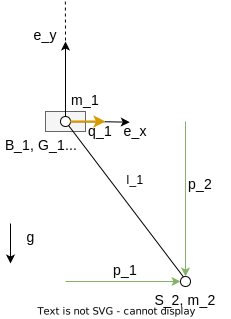

In [57]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_single_crane_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 2 # number of passive coordinates (not directly actuated) -> x_load, y_load
nq = 1 # number of actuated coordinates -> x_1
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(2+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

aa.T := [a₁  a₂]

---

ttheta.T := [p₁  p₂  q₁]

---

tthetad.T := [ṗ₁  ṗ₂  q̇₁]

---

tthetadd.T := [p̈₁  p̈₂  q̈₁]

---

tthetaddd.T := [p⃛₁  p⃛₂  q⃛₁]

---

tthetadddd.T := [p⃜₁  p⃜₂  q⃜₁]

---

QQ.T := [Q₁  Q₂  Q₃]

---

In [4]:
# symbols for analytic equations
params = sp.symbols('m1, m2, l1, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2 = ttau = st.symb_vector("tau1, tau2")


Specify the geometry (joints G and centers of masses S)

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# Time derivatives of centers of masses
Sd1, Sd2 = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##:

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

(Sd1, Sd2) := ⎛⎡q̇₁⎤  ⎡ṗ₁⎤⎞
⎜⎢  ⎥, ⎢  ⎥⎟
⎝⎣0 ⎦  ⎣ṗ₂⎦⎠

---

In [6]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0]

T = T1 + T2 ##:

# potential energy
V = m2*g*S2[1] ##:

---

---

this model is very easy ...

In [7]:
mod = mt.generate_symbolic_model(T, V, ttheta, QQ)
mod.eqns

⎡   -Q₁ + m₂⋅p̈₁    ⎤
⎢                  ⎥
⎢-Q₂ + g⋅m₂ + m₂⋅p̈₂⎥
⎢                  ⎥
⎣   -Q₃ + m₁⋅q̈₁    ⎦

... but $Q_i$ are yet unknown → calculate them via the principle of virtual work, see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Generalized_forces#Virtual_work):
$$
\delta W = \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_1} \delta q_1 +\ldots + \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_m} \delta q_m.
$$

- $ \mathbf {F}_{i}$ applied forces, i.e.  $i=1,2$ → cart-forces, $i=3,4$ → rope-foces
- $ \mathbf {r}_{i}$ position vectors of each particle (along the direction of forces): $i=1,3$ → cart, $i=2$ → load
- $ \mathbf {\delta r}_{i}$ virtual displacement
- $ \mathbf \delta q_{j} = \delta \theta_{j}$ virtual displacement of generalized coordinates


The virtual work of a system of particles can be written in the form

$$
    \delta W = Q_1\delta q_1 + \ldots + Q_m\delta q_m,
$$
where

$$
    Q_j = \sum_{i=1}^n \frac {\partial \mathbf {r}_i} {\partial q_j} \cdot \mathbf {F}_{i}  ,\quad j=1,\ldots, m, 
$$

In [8]:
F1 = sp.Matrix([tau1, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope = (S2 - S1)

uv_rope = rope/sp.sqrt((rope.T*rope)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope = rope/l1

F2 = uv_rope * tau2 ##:

F1.T := [τ₁  0]

---

F2 := ⎡τ₂⋅(p₁ - q₁)⎤
⎢────────────⎥
⎢     l₁     ⎥
⎢            ⎥
⎢   p₂⋅τ₂    ⎥
⎢   ─────    ⎥
⎣     l₁     ⎦

---

In [9]:
dt1, dt2, dt3 = ddelta_theta = st.symb_vector(f"\\delta\\theta_1:{n+1}") ##:

ddelta_theta := ⎡\delta\theta₁⎤
⎢             ⎥
⎢\delta\theta₂⎥
⎢             ⎥
⎣\delta\theta₃⎦

---

In [10]:
ttheta

⎡p₁⎤
⎢  ⎥
⎢p₂⎥
⎢  ⎥
⎣q₁⎦

In [11]:
delta_S1 = S1*0
delta_S2 = S2*0

for theta, delta_theta in zip(ttheta, ddelta_theta):
    
    delta_S1 += S1.diff(theta)*delta_theta
    delta_S2 += S2.diff(theta)*delta_theta
    
delta_S1 ##:
delta_S2 ##:

(delta_S1) := ⎡\delta\theta₃⎤
⎢             ⎥
⎣      0      ⎦

---

(delta_S2) := ⎡\delta\theta₁⎤
⎢             ⎥
⎣\delta\theta₂⎦

---

In [12]:
# simple part (cart)
delta_W = delta_S1.T*F1

# rope (F2 > 0 means rope is pushing from S1 towards S2)
delta_W = delta_W + delta_S2.T*F2 - delta_S1.T*F2 ##:

# convert from 1x1 Matrix to scalar:
# delta_W = delta_W[0, 0] ##:

delta_W := ⎡\delta\theta₁⋅τ₂⋅(p₁ - q₁)   \delta\theta₂⋅p₂⋅τ₂                      \delta\
⎢────────────────────────── + ─────────────────── + \delta\theta₃⋅τ₁ - ───────
⎣            l₁                        l₁                                     

theta₃⋅τ₂⋅(p₁ - q₁)⎤
───────────────────⎥
     l₁            ⎦

---

In [13]:
QQ_expr = delta_W.jacobian(ddelta_theta).T ##:

QQ_expr := ⎡  τ₂⋅(p₁ - q₁)   ⎤
⎢  ────────────   ⎥
⎢       l₁        ⎥
⎢                 ⎥
⎢      p₂⋅τ₂      ⎥
⎢      ─────      ⎥
⎢        l₁       ⎥
⎢                 ⎥
⎢     τ₂⋅(p₁ - q₁)⎥
⎢τ₁ - ────────────⎥
⎣          l₁     ⎦

---

In [14]:
mod.eqns

⎡   -Q₁ + m₂⋅p̈₁    ⎤
⎢                  ⎥
⎢-Q₂ + g⋅m₂ + m₂⋅p̈₂⎥
⎢                  ⎥
⎣   -Q₃ + m₁⋅q̈₁    ⎦

In [15]:
eqns = mod.eqns.subz(QQ, QQ_expr) ##:

eqns := ⎡          τ₂⋅(p₁ - q₁)   ⎤
⎢  m₂⋅p̈₁ - ────────────   ⎥
⎢               l₁        ⎥
⎢                         ⎥
⎢                 p₂⋅τ₂   ⎥
⎢  g⋅m₂ + m₂⋅p̈₂ - ─────   ⎥
⎢                   l₁    ⎥
⎢                         ⎥
⎢             τ₂⋅(p₁ - q₁)⎥
⎢m₁⋅q̈₁ - τ₁ + ────────────⎥
⎣                  l₁     ⎦

---

In [16]:
eqns.jacobian(ttau)

⎡    -(p₁ - q₁) ⎤
⎢0   ───────────⎥
⎢         l₁    ⎥
⎢               ⎥
⎢       -p₂     ⎥
⎢0      ────    ⎥
⎢        l₁     ⎥
⎢               ⎥
⎢      p₁ - q₁  ⎥
⎢-1    ───────  ⎥
⎣         l₁    ⎦

In [17]:
# eliminate the 3rd equation and tau1 → 2 remaining equations

In [18]:
eqns1 = eqns[:-1, :] ##:

eqns1 := ⎡        τ₂⋅(p₁ - q₁)⎤
⎢m₂⋅p̈₁ - ────────────⎥
⎢             l₁     ⎥
⎢                    ⎥
⎢               p₂⋅τ₂⎥
⎢g⋅m₂ + m₂⋅p̈₂ - ─────⎥
⎣                 l₁ ⎦

---

The second remaining equation is used to eliminate $\tau_2$. The first one is then used to eleminate and parametrize $q_1$:

In [22]:
eqns2 = eqns1[0, :] ##:

eqns2 := ⎡        τ₂⋅(p₁ - q₁)⎤
⎢m₂⋅p̈₁ - ────────────⎥
⎣             l₁     ⎦

---

So there is a flat output $\mathbf{y} = (p_1, p_2)^T$ that can be used to parametrize the whole system with it and its derivatives.

# System parameterization by flat output

In [40]:
flat_tau2 = sp.solve(eqns1[-1], tau2)[0]
flat_tau2 = flat_tau2.smplf ##:

---

---

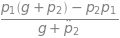

---

In [48]:
flat_q1 = sp.solve(eqns2[0], q1)[0]
flat_q1 = flat_q1.smplf ##:
flat_q1 = flat_q1.subs(tau2, flat_tau2)
flat_q1 = flat_q1.smplf ##:

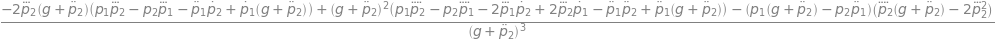

---

In [52]:
# generate 2nd order derivative of flat_q1 for tau1:
flat_qddot1 = st.time_deriv(flat_q1, ttheta, order=2) 
flat_qddot1 = flat_qddot1.smplf ##:

---

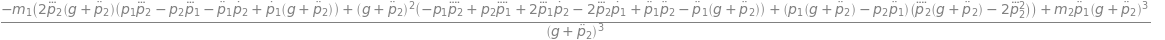

---

In [55]:
flat_tau1 = sp.solve(eqns[-1], tau1)[0]
flat_tau1 = flat_tau1.smplf ##:
flat_tau1 = flat_tau1.subz([tau2, qddot1, q1], [flat_tau2, flat_qddot1, flat_q1])
flat_tau1 = flat_tau1.smplf ##:

In [63]:
# equations of motions generate LaTeX-Code for the video:
from symbtools import interactive_aux as ia
ia.adapted_latex(flat_tau1)

\frac{- m_{1} \left(2 \dddot{p}_{2} \left(g + \ddot{p}_{2}\right) \left(p_{1} \dddot{p}_{2} - p_{2} \dddot{p}_{1} - \ddot{p}_{1} \dot{p}_{2} + \dot{p}_{1} \left(g + \ddot{p}_{2}\right)\right) + \left(g + \ddot{p}_{2}\right)^{2} \left(- p_{1} \ddddot{p}_{2} + p_{2} \ddddot{p}_{1} + 2 \dddot{p}_{1} \dot{p}_{2} - 2 \dddot{p}_{2} \dot{p}_{1} + \ddot{p}_{1} \ddot{p}_{2} - \ddot{p}_{1} \left(g + \ddot{p}_{2}\right)\right) + \left(p_{1} \left(g + \ddot{p}_{2}\right) - p_{2} \ddot{p}_{1}\right) \left(\ddddot{p}_{2} \left(g + \ddot{p}_{2}\right) - 2 \dddot{p}_{2}^{2}\right)\right) + m_{2} \ddot{p}_{1} \left(g + \ddot{p}_{2}\right)^{3}}{\left(g + \ddot{p}_{2}\right)^{3}}
% -------------
